In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
tf.__version__

'2.0.0'

In [6]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)


In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [8]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['roses', 'daisy', 'sunflowers', 'dandelion', 'tulips'],
      dtype='<U10')

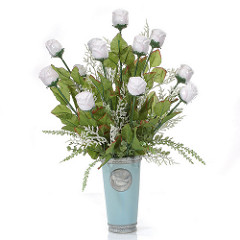

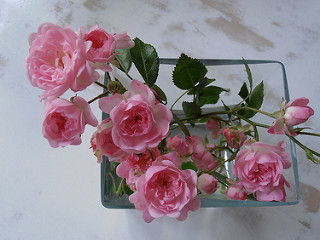

In [9]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:2]:
    display.display(Image.open(str(image_path)))


In [10]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [11]:
BATCH_SIZE = 32
IMG_HEIGHT = 500
IMG_WIDTH = 500
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)


In [12]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))


Found 3670 images belonging to 5 classes.


In [13]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')


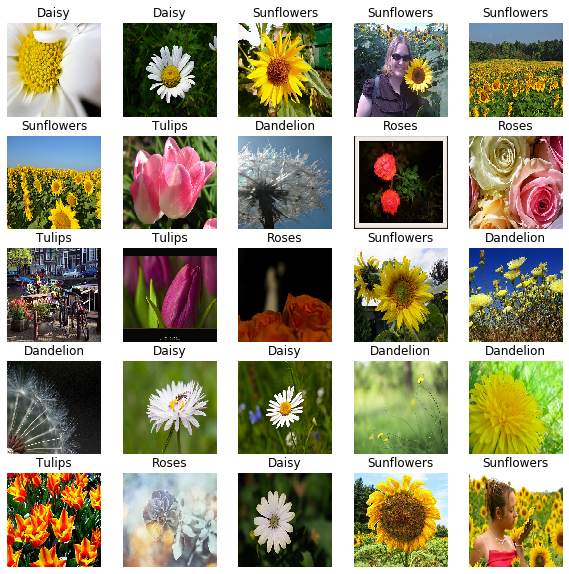

In [14]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)


In [15]:
data_dir

PosixPath('/home/frederik/.keras/datasets/flower_photos')

In [16]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))


In [17]:
for f in list_ds.take(5):
  print(f.numpy())


b'/home/frederik/.keras/datasets/flower_photos/roses/6347846687_3f0a7c3176.jpg'
b'/home/frederik/.keras/datasets/flower_photos/daisy/14921511479_7b0a647795.jpg'
b'/home/frederik/.keras/datasets/flower_photos/roses/3550491463_3eb092054c_m.jpg'
b'/home/frederik/.keras/datasets/flower_photos/daisy/107592979_aaa9cdfe78_m.jpg'
b'/home/frederik/.keras/datasets/flower_photos/tulips/5811022098_2523ca4e82.jpg'


In [18]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [19]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


In [20]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [21]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [22]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


Image shape:  (500, 500, 3)
Label:  [False False False  True False]


In [33]:
def prepare_for_training(ds, cache="./flowers.tfcache", shuffle_buffer_size=500):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [34]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))


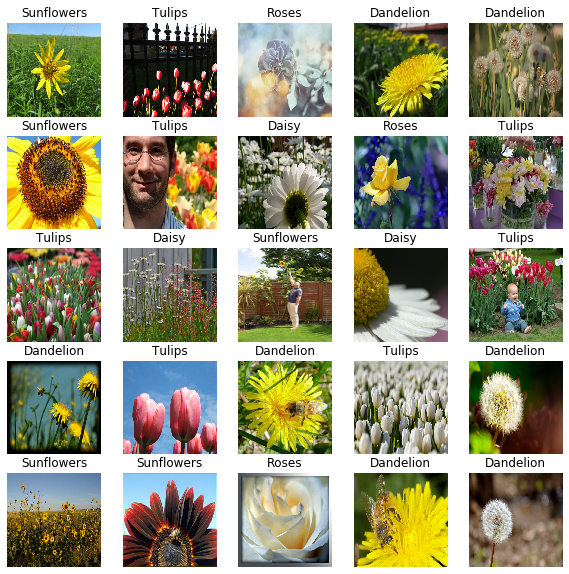

In [35]:
show_batch(image_batch.numpy(), label_batch.numpy())


In [36]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))


In [37]:
# `keras.preprocessing`
#timeit(train_data_gen)


In [38]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)


....................................................................................................
1000 batches: 106.56478667259216 s
300.28681 Images/s
